In [1]:
!pip install langdetect -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 20.4 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=a9d85aec5f8f7e3530bd5c3fa1c69a4f996c2834f0bc753d955fbab1d66f9949
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 
import urllib.request
from tqdm import tqdm
from langdetect import detect, DetectorFactory
from concurrent.futures import ThreadPoolExecutor, as_completed

In [3]:
df = pd.read_csv('/kaggle/input/goodreads-best-books/book_data.csv')
df.shape

(54301, 12)

In [4]:
df.columns

Index(['book_authors', 'book_desc', 'book_edition', 'book_format', 'book_isbn',
       'book_pages', 'book_rating', 'book_rating_count', 'book_review_count',
       'book_title', 'genres', 'image_url'],
      dtype='object')

In [5]:
df = df.rename(columns={
    'book_authors': 'authors',
    'book_desc': 'description',
    'book_edition': 'edition',
    'book_format': 'format',
    'book_isbn': 'isbn',
    'book_pages': 'num_pages',
    'book_rating': 'avg_rating',
    'book_rating_count': 'num_ratings',
    'book_review_count': 'num_reviews',
    'book_title': 'title',
    'genres': 'genres',
    'image_url': 'image_url'
})

In [6]:
df.shape

(54301, 12)

In [7]:
df.isna().sum()

authors            0
description     1331
edition        48848
format          1656
isbn           12866
num_pages       2522
avg_rating         0
num_ratings        0
num_reviews        0
title              0
genres          3242
image_url        683
dtype: int64

# Handling missing values

In [8]:
df = df.dropna(subset=['description', 'image_url']).reset_index(drop=True)
df.shape

(52536, 12)

# Non English Description

In [9]:
df['description'].iloc[3]

"«È cosa ormai risaputa che a uno scapolo in possesso di un'ingente fortuna manchi soltanto una moglie. Questa verità è cosí radicata nella mente delle famiglie del luoho che, nel momento in cui un simile personaggio viene a far parte del vicinato, prima ancora di conoscere anche lontanamente i suoi desiderî in proposito, viene immediatamente considerato come proprietà legittima di una o l'altra delle loro figlie.»Orgoglio e pregiudizio è uno dei primi romanzi di Jane Austen. La scrittrice lo iniziò a ventun anni; il libro, rifiutato da un editore londinese, rimase in un cassetto fino alla sua pubblicazione anonima nel 1813, e da allora è considerato tra i piú importanti romanzi della letteratura inglese. È la storia delle cinque sorelle Bennet e dei loro corteggiatori, con al centro il romantico contrasto tra l'adorabile e capricciosa Elizabeth e l'altezzoso Darcy; lo spirito di osservazione implacabile e quasi cinico, lo studio arguto dei caratteri, la satira delle vanità e delle deb

In [10]:
DetectorFactory.seed = 0

In [11]:
def detect_language_safe(text):
    try:
        return detect(text)
    except:
        return "unknown"

In [12]:
tqdm.pandas(desc="Detecting language of descriptions")
df['lang'] = df['description'].progress_apply(detect_language_safe)

Detecting language of descriptions: 100%|██████████| 52536/52536 [02:37<00:00, 333.91it/s]


In [13]:
df[['description', 'lang']] 

,description,lang
0,Winning will make you famous. Losing means cer...,en
1,There is a door at the end of a silent corrido...,en
2,The unforgettable novel of a childhood in a sl...,en
3,«È cosa ormai risaputa che a uno scapolo in po...,it
4,About three things I was absolutely positive.F...,en
...,...,...
52531,Avi Steinberg is stumped. After defecting from...,en
52532,"In this fearless and half-crazy story, Howard ...",en
52533,From the icons of the game to the players who ...,en
52534,"Soon to be a major motion picture, from Brad P...",en


In [14]:
df = df[df['lang'] == 'en'].reset_index(drop=True)
df.shape

(45647, 13)

# Checking imgs

In [15]:
url = df['image_url'].iloc[0]
resp = urllib.request.urlopen(url)
image = np.asarray(bytearray(resp.read()), dtype="uint8")
img = cv2.imdecode(image, cv2.IMREAD_COLOR)

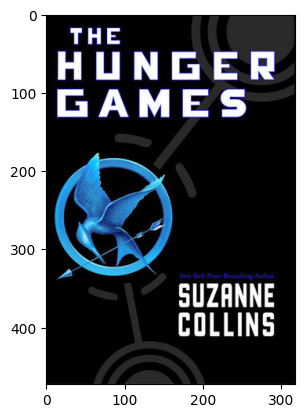

In [16]:
plt.imshow(img)

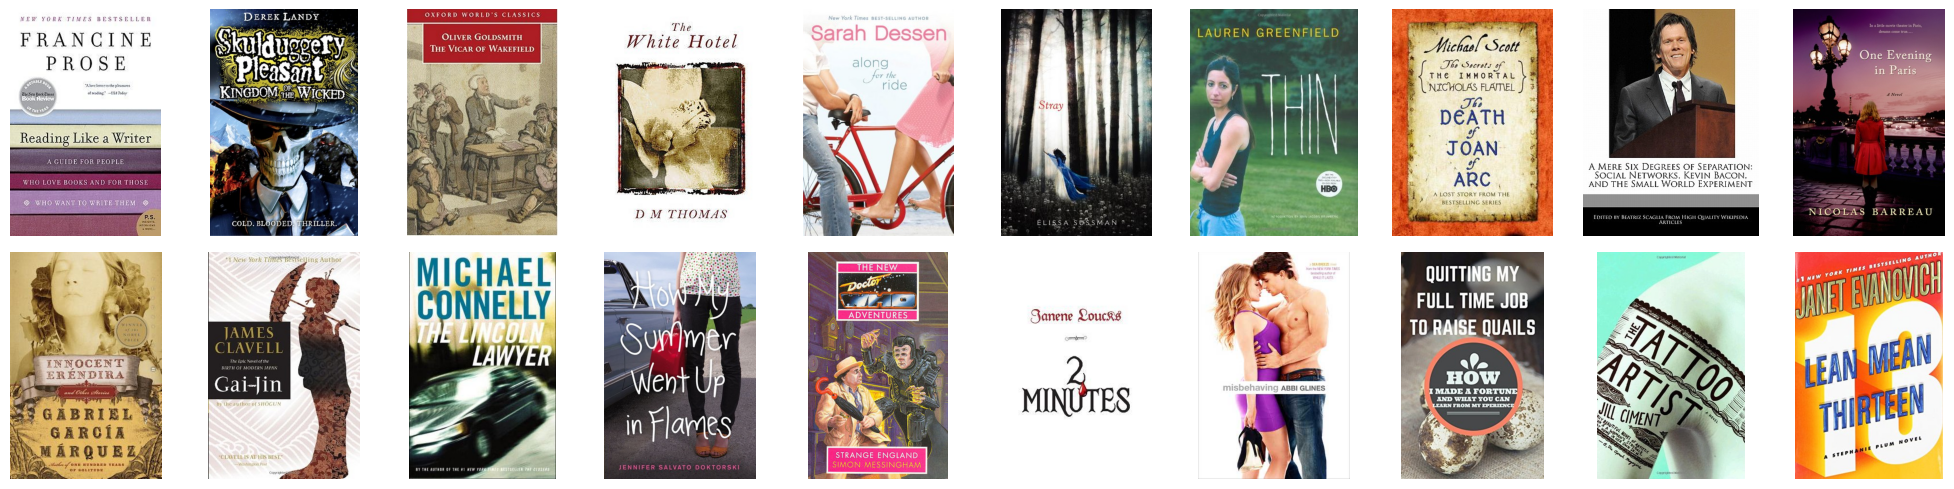

In [17]:
# Choose 20 random image URLs
sample_urls = df['image_url'].dropna().sample(20).tolist()

# Create figure
fig, axes = plt.subplots(2, 10, figsize=(20, 5))
axes = axes.flatten()

for ax, url in zip(axes, sample_urls):
    try:
        # Fetch image from URL
        resp = urllib.request.urlopen(url, timeout=5)
        image = np.asarray(bytearray(resp.read()), dtype="uint8")
        img = cv2.imdecode(image, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

        ax.imshow(img)
        ax.axis("off")

    except Exception as e:
        ax.text(0.5, 0.5, "Error", ha='center', va='center', fontsize=8)
        ax.axis("off")

plt.tight_layout()
plt.show()

# Checking types

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45647 entries, 0 to 45646
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   authors      45647 non-null  object 
 1   description  45647 non-null  object 
 2   edition      4138 non-null   object 
 3   format       44932 non-null  object 
 4   isbn         36895 non-null  object 
 5   num_pages    43901 non-null  object 
 6   avg_rating   45647 non-null  float64
 7   num_ratings  45647 non-null  int64  
 8   num_reviews  45647 non-null  int64  
 9   title        45647 non-null  object 
 10  genres       43566 non-null  object 
 11  image_url    45647 non-null  object 
 12  lang         45647 non-null  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 4.5+ MB


In [19]:
df['num_pages'] = df['num_pages'].astype(str).str.extract(r'(\d+)').astype(float)
df['num_pages'].head(2)

0    374.0
1    870.0
Name: num_pages, dtype: float64

In [20]:
df['genres'] = df['genres'].fillna('Unknown')

In [21]:
df['genres'] = df['genres'].apply(lambda x: [g.strip().lower() for g in x.split('|') if g])

In [22]:
df.shape

(45647, 13)

In [23]:
df = df.drop_duplicates(subset=['title'], keep='first').reset_index(drop=True)
df.shape

(40310, 13)

In [24]:
df.head()

,authors,description,edition,format,isbn,num_pages,avg_rating,num_ratings,num_reviews,title,genres,image_url,lang
0,Suzanne Collins,Winning will make you famous. Losing means cer...,NaN,Hardcover,9.78044E+12,374.0,4.33,5519135,160706,The Hunger Games,"[young adult, fiction, science fiction, dystop...",https://images.gr-assets.com/books/1447303603l...,en
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.78044E+12,870.0,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,"[fantasy, young adult, fiction]",https://images.gr-assets.com/books/1255614970l...,en
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.78006E+12,324.0,4.27,3745197,79450,To Kill a Mockingbird,"[classics, fiction, historical, historical fic...",https://images.gr-assets.com/books/1361975680l...,en
3,Stephenie Meyer,About three things I was absolutely positive.F...,NaN,Paperback,9.78032E+12,498.0,3.58,4281268,97991,Twilight,"[young adult, fantasy, romance, paranormal, va...",https://images.gr-assets.com/books/1361039443l...,en
4,Markus Zusak,Trying to make sense of the horrors of World W...,First American Edition (US / CAN),Hardcover,9.78038E+12,552.0,4.36,1485632,100821,The Book Thief,"[historical, historical fiction, fiction, youn...",https://images.gr-assets.com/books/1522157426l...,en


In [25]:
df['edition'] = df['edition'].fillna('Unknown').str.strip().str.title()
df['format'] = df['format'].fillna('Unknown').str.strip().str.title()

In [26]:
df.head()

,authors,description,edition,format,isbn,num_pages,avg_rating,num_ratings,num_reviews,title,genres,image_url,lang
0,Suzanne Collins,Winning will make you famous. Losing means cer...,Unknown,Hardcover,9.78044E+12,374.0,4.33,5519135,160706,The Hunger Games,"[young adult, fiction, science fiction, dystop...",https://images.gr-assets.com/books/1447303603l...,en
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,Us Edition,Paperback,9.78044E+12,870.0,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,"[fantasy, young adult, fiction]",https://images.gr-assets.com/books/1255614970l...,en
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50Th Anniversary,Paperback,9.78006E+12,324.0,4.27,3745197,79450,To Kill a Mockingbird,"[classics, fiction, historical, historical fic...",https://images.gr-assets.com/books/1361975680l...,en
3,Stephenie Meyer,About three things I was absolutely positive.F...,Unknown,Paperback,9.78032E+12,498.0,3.58,4281268,97991,Twilight,"[young adult, fantasy, romance, paranormal, va...",https://images.gr-assets.com/books/1361039443l...,en
4,Markus Zusak,Trying to make sense of the horrors of World W...,First American Edition (Us / Can),Hardcover,9.78038E+12,552.0,4.36,1485632,100821,The Book Thief,"[historical, historical fiction, fiction, youn...",https://images.gr-assets.com/books/1522157426l...,en


In [27]:
df.to_csv("clean_books_dataset.csv.gz", index=False, compression="gzip")

In [28]:
# Save cleaned dataset to CSV
output_path = "clean_books_dataset.csv"
df.to_csv(output_path, index=False, encoding="utf-8")

print(f"✅ Cleaned dataset saved successfully to {output_path}")

✅ Cleaned dataset saved successfully to clean_books_dataset.csv


# NLP Start

In [29]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [30]:
df.columns

Index(['authors', 'description', 'edition', 'format', 'isbn', 'num_pages',
       'avg_rating', 'num_ratings', 'num_reviews', 'title', 'genres',
       'image_url', 'lang'],
      dtype='object')

In [31]:
books_df = df[['title', 'description', 'genres', 'image_url']]
books_df

,title,description,genres,image_url
0,The Hunger Games,Winning will make you famous. Losing means cer...,"[young adult, fiction, science fiction, dystop...",https://images.gr-assets.com/books/1447303603l...
1,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,"[fantasy, young adult, fiction]",https://images.gr-assets.com/books/1255614970l...
2,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...,"[classics, fiction, historical, historical fic...",https://images.gr-assets.com/books/1361975680l...
3,Twilight,About three things I was absolutely positive.F...,"[young adult, fantasy, romance, paranormal, va...",https://images.gr-assets.com/books/1361039443l...
4,The Book Thief,Trying to make sense of the horrors of World W...,"[historical, historical fiction, fiction, youn...",https://images.gr-assets.com/books/1522157426l...
...,...,...,...,...
40305,Running the Books: The Adventures of an Accide...,Avi Steinberg is stumped. After defecting from...,"[nonfiction, autobiography, memoir, biography,...",https://images.gr-assets.com/books/1320533033l...
40306,Taking the Field: A Fan's Quest to Run the Tea...,"In this fearless and half-crazy story, Howard ...","[sports, baseball, sports and games, sports, n...",https://images.gr-assets.com/books/1312074392l...
40307,"The Baseball Talmud: Koufax, Greenberg, and th...",From the icons of the game to the players who ...,"[nonfiction, sports and games, sports]",https://images.gr-assets.com/books/1348841629l...
40308,He Wanted the Moon: The Madness and Medical Ge...,"Soon to be a major motion picture, from Brad P...","[nonfiction, autobiography, memoir, biography,...",https://images.gr-assets.com/books/1403192135l...


In [32]:
books_df = books_df.copy()
books_df['text'] = books_df['title'] + " " + books_df['description']
books_df['text']

0        The Hunger Games Winning will make you famous....
1        Harry Potter and the Order of the Phoenix Ther...
2        To Kill a Mockingbird The unforgettable novel ...
3        Twilight About three things I was absolutely p...
4        The Book Thief Trying to make sense of the hor...
                               ...                        
40305    Running the Books: The Adventures of an Accide...
40306    Taking the Field: A Fan's Quest to Run the Tea...
40307    The Baseball Talmud: Koufax, Greenberg, and th...
40308    He Wanted the Moon: The Madness and Medical Ge...
40309    The Anthology and the Rise of the Novel: From ...
Name: text, Length: 40310, dtype: object

### Preprocessing

In [33]:
# Download necessary resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [34]:
# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [35]:
def preprocess_text(text):
    # Normalisation (lowercase)
    text = text.lower()

    # Remove punctuation & non-informative symbols
    text = re.sub(r'[^a-z0-9\s]', '', text)
    
    # Supprimer les espaces multiples
    text = re.sub(r'\s+', ' ', text)

    # Supprimer les espaces en début/fin
    text = text.strip()

    # Tokenisation
    tokens = nltk.word_tokenize(text)

    # Remove stopwords and short tokens
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]

    # Lemmatisation (base form)
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    # Join back into a clean string
    return " ".join(tokens)

In [36]:
from tqdm import tqdm
tqdm.pandas(desc="Preprocessing text")

books_df['cleaned_text'] = books_df['text'].progress_apply(preprocess_text)

Preprocessing text: 100%|██████████| 40310/40310 [00:34<00:00, 1183.47it/s]


In [37]:
books_df['cleaned_text']

0        hunger game winning make famous losing mean ce...
1        harry potter order phoenix door end silent cor...
2        kill mockingbird unforgettable novel childhood...
3        twilight three thing absolutely positivefirst ...
4        book thief trying make sense horror world war ...
                               ...                        
40305    running book adventure accidental prison libra...
40306    taking field fan quest run team love fearless ...
40307    baseball talmud koufax greenberg quest ultimat...
40308    wanted moon madness medical genius perry baird...
40309    anthology rise novel richardson george eliot a...
Name: cleaned_text, Length: 40310, dtype: object

In [38]:
books_df

,title,description,genres,image_url,text,cleaned_text
0,The Hunger Games,Winning will make you famous. Losing means cer...,"[young adult, fiction, science fiction, dystop...",https://images.gr-assets.com/books/1447303603l...,The Hunger Games Winning will make you famous....,hunger game winning make famous losing mean ce...
1,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,"[fantasy, young adult, fiction]",https://images.gr-assets.com/books/1255614970l...,Harry Potter and the Order of the Phoenix Ther...,harry potter order phoenix door end silent cor...
2,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...,"[classics, fiction, historical, historical fic...",https://images.gr-assets.com/books/1361975680l...,To Kill a Mockingbird The unforgettable novel ...,kill mockingbird unforgettable novel childhood...
3,Twilight,About three things I was absolutely positive.F...,"[young adult, fantasy, romance, paranormal, va...",https://images.gr-assets.com/books/1361039443l...,Twilight About three things I was absolutely p...,twilight three thing absolutely positivefirst ...
4,The Book Thief,Trying to make sense of the horrors of World W...,"[historical, historical fiction, fiction, youn...",https://images.gr-assets.com/books/1522157426l...,The Book Thief Trying to make sense of the hor...,book thief trying make sense horror world war ...
...,...,...,...,...,...,...
40305,Running the Books: The Adventures of an Accide...,Avi Steinberg is stumped. After defecting from...,"[nonfiction, autobiography, memoir, biography,...",https://images.gr-assets.com/books/1320533033l...,Running the Books: The Adventures of an Accide...,running book adventure accidental prison libra...
40306,Taking the Field: A Fan's Quest to Run the Tea...,"In this fearless and half-crazy story, Howard ...","[sports, baseball, sports and games, sports, n...",https://images.gr-assets.com/books/1312074392l...,Taking the Field: A Fan's Quest to Run the Tea...,taking field fan quest run team love fearless ...
40307,"The Baseball Talmud: Koufax, Greenberg, and th...",From the icons of the game to the players who ...,"[nonfiction, sports and games, sports]",https://images.gr-assets.com/books/1348841629l...,"The Baseball Talmud: Koufax, Greenberg, and th...",baseball talmud koufax greenberg quest ultimat...
40308,He Wanted the Moon: The Madness and Medical Ge...,"Soon to be a major motion picture, from Brad P...","[nonfiction, autobiography, memoir, biography,...",https://images.gr-assets.com/books/1403192135l...,He Wanted the Moon: The Madness and Medical Ge...,wanted moon madness medical genius perry baird...


In [39]:
# df.to_csv("processed_books_dataset.csv.gz", index=False, compression="gzip")

In [40]:
# Save preprocessed dataset to CSV
output_path = "processed_books_dataset.csv"
df.to_csv(output_path, index=False, encoding="utf-8")

print(f"✅ Cleaned dataset saved successfully to {output_path}")

✅ Cleaned dataset saved successfully to processed_books_dataset.csv


In [93]:
from IPython.display import display, HTML

def show_search_results(top_indices, similarities, books_df):
    """
    Display book search results (TF-IDF, Word2Vec, or Sentence Embeddings).
    
    Parameters:
    - top_indices: list/array of document indices
    - similarities: list/array of similarity scores (same length as top_indices)
    - books_df: DataFrame containing book info
    """
    # Convert similarities to list (in case it's numpy)
    similarities = list(similarities)

    # Loop through each result
    for rank, i in enumerate(top_indices):
        row = books_df.iloc[i]

        # Safely handle missing or broken images
        img_url = row.get("image_url", None)
        if img_url and isinstance(img_url, str) and img_url.startswith("http"):
            img_html = f'<img src="{img_url}" width="120" style="border-radius:10px; margin-right:15px;">'
        else:
            img_html = '<div style="width:120px;height:180px;background:#ccc;border-radius:10px;display:inline-block;margin-right:15px;"></div>'
        
        # Info
        title = f"<b>{row.get('title', 'Unknown Title')}</b>"
        score = f"<i>Similarity:</i> {similarities[rank]:.3f}"
        genres = ", ".join(row['genres']) if isinstance(row.get('genres'), list) else row.get('genres', 'N/A')
        description = row.get('description', '')
        description = (description[:250] + "...") if isinstance(description, str) and len(description) > 0 else "No description available."

        # HTML layout
        html = f"""
        <div style="display:flex;align-items:flex-start;margin-bottom:20px;">
            {img_html}
            <div>
                <div style="font-size:16px;">{title}</div>
                <div style="color:gray;font-size:14px;">{score}</div>
                <div style="color:#555;font-size:13px;margin-top:5px;"><b>Genres:</b> {genres}</div>
                <div style="margin-top:8px;font-size:13px;">{description}</div>
            </div>
        </div>
        <hr style="border:0;border-top:1px solid #eee;margin:10px 0;">
        """
        display(HTML(html))

# TF-IDF

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [42]:
# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(books_df['cleaned_text'])

In [43]:
tfidf_vectorizer.get_feature_names_out()

array(['100', '1920s', '1930s', ..., 'zombie', 'zone', 'zoo'],
      dtype=object)

In [44]:
print("✅ TF-IDF matrix shape:", tfidf_matrix.shape)

✅ TF-IDF matrix shape: (40310, 5000)


In [94]:
# Exemple de requête utilisateur
query = "girl who steals books during the world war"

# Vectoriser la requête avec le même modèle
query_vec = tfidf_vectorizer.transform([query])

# Calculer similarité cosinus entre la requête et tous les documents
cosine_similarities = cosine_similarity(query_vec, tfidf_matrix).flatten()

# Récupérer les indices des documents les plus similaires
top_indices = cosine_similarities.argsort()[-6:][::-1]

# # Afficher les meilleurs résultats
# for i in top_indices:
#     print(f"📘 Book {i} — Score: {cosine_similarities[i]:.3f}")
#     print(books_df.iloc[i]['title'])
#     print(f"{row['description'][:200]}...")
#     print("-" * 80)

show_search_results(top_indices, cosine_similarities[top_indices], books_df)


# Word2Vec

In [46]:
!pip install gensim -q

In [47]:
import gensim
from gensim.models import Word2Vec
from sklearn.neighbors import NearestNeighbors

In [48]:
tokenized_texts = [doc.split() for doc in books_df['cleaned_text']]
len(tokenized_texts)

40310

In [67]:
tokenized_texts = [doc.split() for doc in books_df['cleaned_text']]

# Train Word2Vec model
w2v_model = Word2Vec(
    sentences=tokenized_texts,
    vector_size=100,   # embedding size
    window=5,
    min_count=2,
    workers=4,
    sg=1               # skip-gram for semantic accuracy
)

In [68]:
# Compute average vector per document
def document_vector(doc):
    words = [w for w in doc if w in w2v_model.wv.key_to_index]
    if len(words) == 0:
        return np.zeros(w2v_model.vector_size)
    return np.mean(w2v_model.wv[words], axis=0)

books_df['w2v_vector'] = books_df['cleaned_text'].apply(document_vector)

In [69]:
# Appliquer à tous les documents
word2vec_vectors = np.array([document_vector(doc) for doc in tokenized_texts])

print("Word2Vec shape:", word2vec_vectors.shape)

Word2Vec shape: (40310, 100)


In [70]:
# Construire l'index
nn = NearestNeighbors(metric='cosine', algorithm='brute')
nn.fit(word2vec_vectors)

NearestNeighbors(algorithm='brute', metric='cosine')

In [95]:

# Requête utilisateur
query = "girl who steals books during the world war"
query_tokens = query.split()

query_vec = document_vector(query_tokens).reshape(1, -1)

# Trouver les 5 voisins les plus proches
distances, indices = nn.kneighbors(query_vec, n_neighbors=6)

# Afficher les résultats
# for i, idx in enumerate(indices[0]):
#     print(f"📘 Book {idx} — Similarity: {1 - distances[0][i]:.4f}")
#     print(books_df.iloc[idx]['title'])
#     print(f"{row['description'][:200]}...")
#     print("-" * 80)


top_indices = indices[0]
similarities = 1 - distances[0]  # convert distance → similarity

show_search_results(top_indices, similarities, books_df)


# Sentence Transfromers

In [54]:
def clean_for_transformer(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s.,!:?]', ' ', text)     # remove unwanted chars but keep punctuation
    text = re.sub(r'\s+', ' ', text)                 # replace multiple spaces/newlines with a single space
    return text.strip()

In [55]:
books_df['transformer_text'] = books_df['title'] + " : " + books_df['description']
books_df['transformer_text'] = books_df['transformer_text'].apply(clean_for_transformer)
books_df['transformer_text']

0        the hunger games : winning will make you famou...
1        harry potter and the order of the phoenix : th...
2        to kill a mockingbird : the unforgettable nove...
3        twilight : about three things i was absolutely...
4        the book thief : trying to make sense of the h...
                               ...                        
40305    running the books: the adventures of an accide...
40306    taking the field: a fan s quest to run the tea...
40307    the baseball talmud: koufax, greenberg, and th...
40308    he wanted the moon: the madness and medical ge...
40309    the anthology and the rise of the novel: from ...
Name: transformer_text, Length: 40310, dtype: object

In [56]:
from sentence_transformers import SentenceTransformer
from sentence_transformers import util

2025-11-10 15:45:57.514083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762789557.679185      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762789557.723465      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [57]:
model = SentenceTransformer('all-MiniLM-L6-v2')
sentence_embeddings = model.encode(books_df['transformer_text'], show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1260 [00:00<?, ?it/s]

In [58]:
sentence_embeddings_arr = np.array(sentence_embeddings)

In [96]:
# def semantic_search(query, top_k=5):
#     # Encode the query
#     query_vec = model.encode([query])
    
#     # Compute cosine similarity
#     similarities = cosine_similarity(query_vec, sentence_embeddings_arr).flatten()
    
#     # Get top-k most similar books
#     top_indices = similarities.argsort()[-top_k:][::-1]
    
#     results = []
#     for i in top_indices:
#         results.append((books_df.iloc[i], float(similarities[i]), int(i)))
#     return results


# query = "girl who steals books during the world war"
# results = semantic_search(query, top_k=10)

# for row, score, idx in results:
#     print(f"📘 {row['title']}  (Score: {score:.3f})")
#     print(f"{row['description'][:200]}...")
#     print("-" * 80)


In [97]:
def semantic_search(query, top_k=6):
    query_vec = model.encode([query])
    similarities = cosine_similarity(query_vec, sentence_embeddings).flatten()
    top_indices = similarities.argsort()[-top_k:][::-1]
    return top_indices, similarities[top_indices]


In [98]:
query = "girl who steals books during the world war"
top_indices, similarities = semantic_search(query, top_k=6)
show_search_results(top_indices, similarities, books_df)

# Finale

In [99]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def search_books(query, mode="tfidf", top_k=10):
    """
    Recherche de livres similaires à une requête utilisateur.

    Params:
        query (str): Texte de la requête.
        mode (str): 'tfidf', 'w2v', or 'sentence'.
        top_k (int): Nombre de résultats à retourner.

    Returns:
        top_indices (list): Indices des livres les plus similaires
        top_similarities (list): Similarités correspondantes
    """
    
    if mode.lower() == "tfidf":
        # Vectoriser la requête
        query_vec = tfidf_vectorizer.transform([query])
        # Cosine similarity
        similarities = cosine_similarity(query_vec, tfidf_matrix).flatten()
        # Top indices
        top_indices = similarities.argsort()[-top_k:][::-1]
        top_similarities = similarities[top_indices]

    elif mode.lower() == "w2v":
        # Tokenize query
        query_tokens = query.split()
        query_vec = document_vector(query_tokens).reshape(1, -1)
        # Nearest neighbors
        distances, indices = nn.kneighbors(query_vec, n_neighbors=top_k)
        top_indices = indices[0]
        top_similarities = 1 - distances[0]  # convert distance → similarity

    elif mode.lower() == "sentence":
        # Encode query
        query_vec = model.encode([query])
        similarities = cosine_similarity(query_vec, sentence_embeddings).flatten()
        top_indices = similarities.argsort()[-top_k:][::-1]
        top_similarities = similarities[top_indices]

    else:
        raise ValueError("Mode inconnu. Choisir 'tfidf', 'w2v', ou 'sentence'.")

    return top_indices, top_similarities

In [105]:
query = "boy who was raised in a jungle among animals"

In [106]:
# Example with TF-IDF
top_indices, top_similarities = search_books(query, mode="tfidf", top_k=10)
show_search_results(top_indices, top_similarities, books_df)

In [107]:
# Example with Word2Vec
top_indices, top_similarities = search_books(query, mode="w2v", top_k=10)
show_search_results(top_indices, top_similarities, books_df)

In [108]:
# Example with Sentence Embeddings
top_indices, top_similarities = search_books(query, mode="sentence", top_k=10)
show_search_results(top_indices, top_similarities, books_df)

In [110]:
!pip install gradio -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [111]:
import gradio as gr
import numpy as np

def format_results_html(top_indices, top_similarities, books_df):
    """
    Generate HTML to display search results with images and info.
    """
    html_output = ""
    for rank, i in enumerate(top_indices):
        row = books_df.iloc[i]
        # Book image
        img_url = row.get("image_url")
        if img_url and isinstance(img_url, str) and img_url.startswith("http"):
            img_html = f'<img src="{img_url}" width="120" style="border-radius:10px; margin-right:15px;">'
        else:
            img_html = '<div style="width:120px;height:180px;background:#ccc;border-radius:10px;display:inline-block;margin-right:15px;"></div>'
        # Info
        title = f"<b>{row.get('title', 'Unknown Title')}</b>"
        score = f"<i>Similarity:</i> {top_similarities[rank]:.3f}"
        genres = ", ".join(row['genres']) if isinstance(row.get('genres'), list) else row.get('genres', 'N/A')
        description = row.get('description', '')
        description = (description[:250] + "...") if isinstance(description, str) and len(description) > 0 else "No description available."
        # HTML block
        html_output += f"""
        <div style="display:flex;align-items:flex-start;margin-bottom:20px;">
            {img_html}
            <div>
                <div style="font-size:16px;">{title}</div>
                <div style="color:gray;font-size:14px;">{score}</div>
                <div style="color:#555;font-size:13px;margin-top:5px;"><b>Genres:</b> {genres}</div>
                <div style="margin-top:8px;font-size:13px;">{description}</div>
            </div>
        </div>
        <hr style="border:0;border-top:1px solid #eee;margin:10px 0;">
        """
    return html_output

# Gradio function
def gradio_search(query, mode, top_k):
    top_indices, top_similarities = search_books(query, mode=mode, top_k=top_k)
    html = format_results_html(top_indices, top_similarities, books_df)
    return html

# Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("<h2>📚 Book Search Engine</h2>")
    
    with gr.Row():
        query_input = gr.Textbox(label="Enter your search query", placeholder="e.g., girl who steals books during the world war")
        mode_input = gr.Dropdown(label="Search Mode", choices=["tfidf", "w2v", "sentence"], value="tfidf")
        top_k_input = gr.Slider(label="Number of results", minimum=1, maximum=20, step=1, value=6)
    
    search_button = gr.Button("Search")
    results_output = gr.HTML()
    
    search_button.click(gradio_search, inputs=[query_input, mode_input, top_k_input], outputs=results_output)

demo.launch()

* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://ea13e6cf2e9cf04de2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
